In [1]:
#hide
#skip
! [ -e /content ] && pip install -Uqq fastai  # upgrade fastai on colab

In [2]:
%load_ext autoreload
%autoreload 2

# Mimic3-9K (Sample)

> API details

In [3]:
import fastbook
fastbook.setup_book()

from fastbook import *

Application specific imports

In [4]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from fastai.text.all import *
from fastai.distributed import *

from xcube.text.learner import text_classifier_learner
from xcube.metrics import PrecisionK

#### Setting the base path as the path of the repository

In [5]:
def namestr(obj, namespace):
    "Returns the name of the object `obj` passed"
    return [name for name in namespace if namespace[name] is obj]

In [6]:
a = 'some_var'
test_eq(namestr(a, globals()), ['a'])

In [7]:
path = Path.cwd()
path_data = path/'data'
path_model = path/'models'

path_model.mkdir(exist_ok=True)
path_data.mkdir(exist_ok=True)

file_prefix = 'mimic3-9k'

data = path_data/(file_prefix+'.csv')
dls_lm_path, dls_lm_r_path = path_model/f"{file_prefix}_dls_lm.pkl", path_model/f"{file_prefix}_dls_lm_r.pkl"
dls_lm_vocab_path, dls_lm_vocab_r_path = path_model/f"{file_prefix}_dls_lm_vocab.pkl", path_model/f"{file_prefix}_dls_lm_vocab_r.pkl"
lm_path, lm_r_path = path_model/f"{file_prefix}_lm.pth", path_model/f"{file_prefix}_lm_r.pth"
lm_finetuned_path, lm_finetuned_r_path = path_model/f"{file_prefix}_lm_finetuned.pth", path_model/f"{file_prefix}_lm_finetuned_r.pth"
dsets_clas_path, dsets_clas_r_path = path_model/f"{file_prefix}_dset_clas.pkl", path_model/f"{file_prefix}_dset_clas_r.pkl"
dls_clas_path, dls_clas_r_path = path_model/f"{file_prefix}_dls_clas.pkl", path_model/f"{file_prefix}_dls_clas_r.pkl"
clas_path, clas_r_path = path_model/f"{file_prefix}_clas.pth", path_model/f"{file_prefix}_clas_r.pth"

plist = [path, path_data, path_model, 
         data, 
         dls_lm_path, dls_lm_r_path,
         dls_lm_vocab_path, dls_lm_vocab_r_path,
         lm_path, lm_r_path,
         lm_finetuned_path, lm_finetuned_r_path,
         dsets_clas_path, dsets_clas_r_path,
         dls_clas_path, dls_clas_r_path,
         clas_path, clas_r_path]
for o in plist:
    print(f"{namestr(o, globals())[0]} = {o}")

path = /home/deb/xcube/nbs/examples/mimic/sample
path_data = /home/deb/xcube/nbs/examples/mimic/sample/data
path_model = /home/deb/xcube/nbs/examples/mimic/sample/models
data = /home/deb/xcube/nbs/examples/mimic/sample/data/mimic3-9k.csv
dls_lm_path = /home/deb/xcube/nbs/examples/mimic/sample/models/mimic3-9k_dls_lm.pkl
dls_lm_r_path = /home/deb/xcube/nbs/examples/mimic/sample/models/mimic3-9k_dls_lm_r.pkl
dls_lm_vocab_path = /home/deb/xcube/nbs/examples/mimic/sample/models/mimic3-9k_dls_lm_vocab.pkl
dls_lm_vocab_r_path = /home/deb/xcube/nbs/examples/mimic/sample/models/mimic3-9k_dls_lm_vocab_r.pkl
lm_path = /home/deb/xcube/nbs/examples/mimic/sample/models/mimic3-9k_lm.pth
lm_r_path = /home/deb/xcube/nbs/examples/mimic/sample/models/mimic3-9k_lm_r.pth
lm_finetuned_path = /home/deb/xcube/nbs/examples/mimic/sample/models/mimic3-9k_lm_finetuned.pth
lm_finetuned_r_path = /home/deb/xcube/nbs/examples/mimic/sample/models/mimic3-9k_lm_finetuned_r.pth
dsets_clas_path = /home/deb/xcube/nbs/exam

In this notebook we are going to create a small sample for the purpose of quick iteration. So below let's create some symlinks that we are going to point to the the main dataset and the language model (Only nned to run the following symlinks once):

To be safe, delete any existing symlinks:

In [40]:
for p in plist:
    if p.is_symlink(): p.unlink()

Symlink the data:

In [41]:
data.symlink_to(path.parent/'data'/(file_prefix+'.csv'))
data

Path('/home/deb/xcube/nbs/examples/mimic/sample/data/mimic3-9k.csv')

Symlink the language model (fwd and bwd):

In [42]:
lm_path.symlink_to(path.parent/'models'/(file_prefix+'_lm.pth'))
lm_path.exists(), lm_path

(True,
 Path('/home/deb/xcube/nbs/examples/mimic/sample/models/mimic3-9k_lm.pth'))

In [43]:
lm_r_path.symlink_to(path.parent/'models'/(file_prefix+'_lm_r.pth'))
lm_r_path.exists(), lm_r_path

(True,
 Path('/home/deb/xcube/nbs/examples/mimic/sample/models/mimic3-9k_lm_r.pth'))

Symlink the language model encoder (fwd and bwd):

In [44]:
lm_finetuned_path.symlink_to(path.parent/'models'/(file_prefix+'_lm_finetuned.pth'))
lm_finetuned_path.exists(), lm_finetuned_path

(True,
 Path('/home/deb/xcube/nbs/examples/mimic/sample/models/mimic3-9k_lm_finetuned.pth'))

In [45]:
lm_finetuned_r_path.symlink_to(path.parent/'models'/(file_prefix+'_lm_finetuned_r.pth'))
lm_finetuned_r_path.exists(), lm_finetuned_r_path

(True,
 Path('/home/deb/xcube/nbs/examples/mimic/sample/models/mimic3-9k_lm_finetuned_r.pth'))

Symlink the language model vocab (fwd and bwd): (Well we don't really need both as those are same.)

In [46]:
dls_lm_vocab_path.symlink_to(path.parent/'models'/(file_prefix+'_dls_lm_vocab.pkl'))
dls_lm_vocab_path.exists(), dls_lm_vocab_path

(True,
 Path('/home/deb/xcube/nbs/examples/mimic/sample/models/mimic3-9k_dls_lm_vocab.pkl'))

In [47]:
dls_lm_vocab_r_path.symlink_to(path.parent/'models'/(file_prefix+'_dls_lm_vocab_r.pkl'))
dls_lm_vocab_r_path.exists(), dls_lm_vocab_r_path

(True,
 Path('/home/deb/xcube/nbs/examples/mimic/sample/models/mimic3-9k_dls_lm_vocab_r.pkl'))

## `DataLoaders` for the Language Model

To be able to use Transfer Learning, first we need to fine-tune our Language Model (which we pretrained on Wikipedia) on the corpus of Wiki-500k (the one we downloaded). Here we will build the `DataLoaders` object using fastai's `DataBlock` API:

In [30]:
# !head -n 1 {data}

In [35]:
df = pd.read_csv(data,
                 header=0,
                 names=['subject_id', 'hadm_id', 'text', 'labels', 'length', 'is_valid'],
                 dtype={'subject_id': str, 'hadm_id': str, 'text': str, 'labels': str, 'length': np.int64, 'is_valid': bool})
len(df)

52726

In [36]:
df[['text', 'labels']] = df[['text', 'labels']].astype(str)

Let's take a look at the data:

In [37]:
df.head(3)

,subject_id,hadm_id,text,labels,length,is_valid
0,86006,111912,admission date discharge date date of birth sex f service surgery allergies patient recorded as having no known allergies to drugs attending first name3 lf chief complaint 60f on coumadin was found slightly drowsy tonight then fell down stairs paramedic found her unconscious and she was intubated w o any medication head ct shows multiple iph transferred to hospital1 for further eval major surgical or invasive procedure none past medical history her medical history is significant for hypertension osteoarthritis involving bilateral knee joints with a dependence on cane for ambulation chronic...,801.35;348.4;805.06;807.01;998.30;707.24;E880.9;427.31;414.01;401.9;V58.61;V43.64;707.00;E878.1;96.71,230,False
1,85950,189769,admission date discharge date service neurosurgery allergies sulfa sulfonamides attending first name3 lf chief complaint cc cc contact info major surgical or invasive procedure none history of present illness hpi 88m who lives with family had fall yesterday today had decline in mental status ems called pt was unresponsive on arrival went to osh head ct showed large r sdh pt was intubated at osh and transferred to hospital1 for further care past medical history cad s p mi in s p cabg in ventricular aneurysm at that time cath in with occluded rca unable to intervene chf reported ef 1st degre...,852.25;E888.9;403.90;585.9;250.00;414.00;V45.81;96.71,304,False
2,88025,180431,admission date discharge date date of birth sex f service surgery allergies no known allergies adverse drug reactions attending first name3 lf chief complaint s p fall major surgical or invasive procedure none history of present illness 45f etoh s p fall from window at feet found ambulating and slurring speech on scene intubated en route for declining mental status in the er the patient was found to be bradycardic to the s with bp of systolic she was given atropine dilantin and was started on saline past medical history unknown social history unknown family history unknown physical exam ex...,518.81;348.4;348.82;801.25;427.89;E882;V49.86;305.00;96.71;38.93,359,False


We will now create the `DataLoaders` using `DataBlock` API:

In [13]:
dls_lm = DataBlock(
    blocks   = TextBlock.from_df('text', is_lm=True),
    get_x    = ColReader('text'),
    splitter = RandomSplitter(0.1)
).dataloaders(df, bs=384, seq_len=80)

Let's take a look at the batches:

In [45]:
dls_lm.show_batch(max_n=2)

/home/deb/miniconda3/lib/python3.9/site-packages/fastai/torch_core.py:476: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ax = ax.append(pd.Series({label: o}))
/home/deb/miniconda3/lib/python3.9/site-packages/fastai/torch_core.py:476: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ax = ax.append(pd.Series({label: o}))
/home/deb/miniconda3/lib/python3.9/site-packages/fastai/torch_core.py:476: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ax = ax.append(pd.Series({label: o}))
/home/deb/miniconda3/lib/python3.9/site-packages/fastai/torch_core.py:476: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ax = ax.append(pd.Series({label: o}))


,text,text_
0,xxbos admission date discharge date date of birth sex m service cardiac surgery chief complaint chest pain history of present illness mr known lastname is a year old man with a history of hypertension who presented to an outside hospital complaining of chest pain radiating to his jaw and arms he went to his local emergency department where they found that his cardiac enzymes were negative his electrocardiogram showed a right bundle branch block and his chest pain was typical,admission date discharge date date of birth sex m service cardiac surgery chief complaint chest pain history of present illness mr known lastname is a year old man with a history of hypertension who presented to an outside hospital complaining of chest pain radiating to his jaw and arms he went to his local emergency department where they found that his cardiac enzymes were negative his electrocardiogram showed a right bundle branch block and his chest pain was typical for
1,outpatient he will need to continue hd m w f first name8 namepattern2 name8 md md doctor first name completed by xxbos admission date discharge date date of birth sex m service medicine allergies keflex vioxx codeine attending last name namepattern1 chief complaint le edema and dyspnea major surgical or invasive procedure none history of present illness 51 m with t2 dm unclear diastolic chf htn and chronic pain on narcotics who presents with worsening le edema and sob at,he will need to continue hd m w f first name8 namepattern2 name8 md md doctor first name completed by xxbos admission date discharge date date of birth sex m service medicine allergies keflex vioxx codeine attending last name namepattern1 chief complaint le edema and dyspnea major surgical or invasive procedure none history of present illness 51 m with t2 dm unclear diastolic chf htn and chronic pain on narcotics who presents with worsening le edema and sob at rehab


The length of our vocabulary is:

In [46]:
len(dls_lm.vocab)

57376

Let's take a look at some words of the vocab:

In [47]:
print(coll_repr(L(dls_lm.vocab), 30))

(#57376) ['xxunk','xxpad','xxbos','xxeos','xxfld','xxrep','xxwrep','xxup','xxmaj','the','and','to','of','was','with','a','on','in','for','mg','no','tablet','patient','is','he','at','blood','name','po','she'...]


Creating the `DataLaoders` takes some time, so smash that *save* button (also a good idea to save the `dls_lm.vocab` for later use):

In [48]:
torch.save(dls_lm, dls_lm_path)
torch.save(dls_lm.vocab, dls_lm_vocab_path)

To load back the `dls_lm` later on:

In [44]:
dls_lm = torch.load(dls_lm_path)

## `Learner` for the Language Model Fine-Tuning:

In [50]:
learn = language_model_learner(
    dls_lm, AWD_LSTM, drop_mult=0.3,
    metrics=[accuracy, Perplexity()]).to_fp16()

Let's compute the learning rate using the `lr_find`:

In [ ]:
lr_min, lr_steep, lr_valley, lr_slide = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))
lr_min, lr_steep, lr_valley, lr_slide

In [20]:
learn.fit_one_cycle(1, lr_min)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,3.646323,3.512013,0.382642,33.515659,2:27:57


It takes quite a while to train each epoch, so we'll be saving the intermediate model results during the training process:

In [21]:
learn.save('lm')

Path('models/lm.pth')

Let's now load back the `Learner`

In [58]:
learn = learn.load('lm')

Let's validate the `Learner` to make sure we loaded the correct version:

In [59]:
learn.validate()

(#3) [2.1801044940948486,0.551633358001709,8.847230911254883]

Since we have completed the initial training, we will now continue fine-tuning the model after unfreezing:

In [20]:
learn.unfreeze()

and run `lr_find` again, because we now have more layers to train, and the last layers weight have already been trained for one epoch:

In [ ]:
lr_min, lr_steep, lr_valley, lr_slide = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))
lr_min, lr_steep, lr_valley, lr_slide

Let's now traing with a suitable learning rate:

In [ ]:
learn.fit_one_cycle(10, lr_max=2e-3, cbs=SaveModelCallback(fname='lm'))

Note: Make sure if you have trained the most language model `Learner` for more epochs (then you need to save that version)

### Saving the encoder of the Language Model

**Crucial:** Once we have trained our LM we will save all of our model except the final layer that converts activation to probabilities of picking each token in our vocabulary. The model not including the final layer has a sexy name - *encoder*. We will save it using `save_encoder` method of the `Learner`:

In [62]:
learn.save_encoder('lm_finetuned')

This completes the second stage of the text classification process - fine-tuning the Language Model pretrained on Wikipedia corpus. We will now use it to fine-tune a text multi-label text classifier.

## `DataLoaders` for the Multi-Label Classifier (using fastai's Mid-Level Data API)

### Loading Raw Data

In [8]:
data

Path('/home/deb/xcube/nbs/examples/mimic/sample/data/mimic3-9k.csv')

In [9]:
# !head -n 1 {data}

In [10]:
# !shuf -n 200000 {data} > {data_sample} 

In [14]:
df = pd.read_csv(data,
                 header=0,
                 names=['subject_id', 'hadm_id', 'text', 'labels', 'length', 'is_valid'],
                 dtype={'subject_id': str, 'hadm_id': str, 'text': str, 'labels': str, 'length': np.int64, 'is_valid': bool})
len(df)

52726

In [15]:
df[['text', 'labels']] = df[['text', 'labels']].astype(str)

In [16]:
df.head(3)

,subject_id,hadm_id,text,labels,length,is_valid
0,86006,111912,admission date discharge date date of birth sex f service surgery allergies patient recorded as having no known allergies to drugs attending first name3 lf chief complaint 60f on coumadin was found slightly drowsy tonight then fell down stairs paramedic found her unconscious and she was intubated w o any medication head ct shows multiple iph transferred to hospital1 for further eval major surgical or invasive procedure none past medical history her medical history is significant for hypertension osteoarthritis involving bilateral knee joints with a dependence on cane for ambulation chronic...,801.35;348.4;805.06;807.01;998.30;707.24;E880.9;427.31;414.01;401.9;V58.61;V43.64;707.00;E878.1;96.71,230,False
1,85950,189769,admission date discharge date service neurosurgery allergies sulfa sulfonamides attending first name3 lf chief complaint cc cc contact info major surgical or invasive procedure none history of present illness hpi 88m who lives with family had fall yesterday today had decline in mental status ems called pt was unresponsive on arrival went to osh head ct showed large r sdh pt was intubated at osh and transferred to hospital1 for further care past medical history cad s p mi in s p cabg in ventricular aneurysm at that time cath in with occluded rca unable to intervene chf reported ef 1st degre...,852.25;E888.9;403.90;585.9;250.00;414.00;V45.81;96.71,304,False
2,88025,180431,admission date discharge date date of birth sex f service surgery allergies no known allergies adverse drug reactions attending first name3 lf chief complaint s p fall major surgical or invasive procedure none history of present illness 45f etoh s p fall from window at feet found ambulating and slurring speech on scene intubated en route for declining mental status in the er the patient was found to be bradycardic to the s with bp of systolic she was given atropine dilantin and was started on saline past medical history unknown social history unknown family history unknown physical exam ex...,518.81;348.4;348.82;801.25;427.89;E882;V49.86;305.00;96.71;38.93,359,False


Sample a small fraction of the dataset to ensure quick iteration:

In [17]:
df = df.sample(frac=0.3, random_state=89, ignore_index=True)
# df = df.sample(frac=0.025, random_state=89, ignore_index=True)
# df = df.sample(frac=0.005, random_state=89, ignore_index=True)
len(df)

15818

Let's now gather the labels from the 'labels' columns of the df:

In [18]:
lbl_freqs = Counter()
for labels in df.labels: lbl_freqs.update(labels.split(';'))

The total number of labels are:

In [19]:
len(lbl_freqs)

6586

Let's take a look at the most common labels:

In [93]:
pd.DataFrame(lbl_freqs.most_common(20), columns=['label', 'frequency'])

,label,frequency
0,401.9,20053
1,38.93,14444
2,428.0,12842
3,427.31,12594
4,414.01,12179
5,96.04,9932
6,96.6,9161
7,584.9,8907
8,250.00,8784
9,96.71,8619


Let's make a list of all labels (We will use it later while creating the `DataLoader`)

In [20]:
lbls = list(lbl_freqs.keys())

### Dataset Statistics 

#### Check #1: Number of instances (train/valid split)

In [29]:
train, valid = df.index[~df['is_valid']], df.index[df['is_valid']]
len(train), len(valid)

(244, 20)

#### Check #2: Avg number of instances per label

In [30]:
array(list(lbl_freqs.values())).mean()

3.341463414634146

#### Check #3: Plotting the label distribution

In [32]:
lbl_count = []
for lbls in df.labels: lbl_count.append(len(lbls.split(',')))

In [85]:
df_copy = df.copy()
df_copy['label_count'] = lbl_count

In [86]:
df_copy.head(2)

,text,labels,is_valid,label_count
0,"Methodical Bible study: A new approach to hermeneutics /SEP/ Methodical Bible study: A new approach to hermeneutics. Inductive study compares related Bible texts in order to let the Bible interpret itself, rather than approaching Scripture with predetermined notions of what it will say. Dr. Trainas Methodical Bible Study was not intended to be the last word in inductive Bible study; but since its first publication in 1952, it has become a foundational text in this field. Christian colleges and seminaries have made it required reading for beginning Bible students, while many churches have...","34141,119299,126600,128716,187372,218742",False,6
1,"Southeastern Mills Roast Beef Gravy Mix, 4.5-Ounce Packages (Pack of 24) /SEP/ Southeastern Mills Roast Beef Gravy Mix, 4.5-Ounce Packages (Pack of 24). Makes 3-1/2 cups. Down home taste. Makes hearty beef stew base.","465536,465553,615429",False,3


The average number of labels per instance is:

In [112]:
df_copy.label_count.mean()

5.385563363865518

/home/deb/miniconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


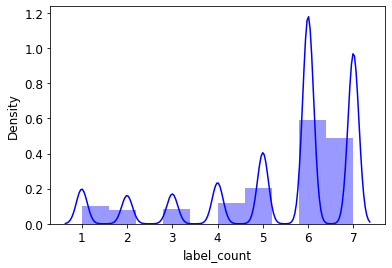

In [87]:
import seaborn as sns
sns.distplot(df_copy.label_count, bins=10, color='b');

In [88]:
lbls_sorted = sorted(lbl_freqs.items(), key=lambda item: item[1], reverse=True)

In [89]:
lbls_sorted[:20]

[('455619', 2258),
 ('455662', 2176),
 ('547041', 2160),
 ('516790', 1214),
 ('455712', 1203),
 ('455620', 1133),
 ('632786', 1132),
 ('632789', 1132),
 ('632785', 1030),
 ('632788', 1030),
 ('492255', 938),
 ('455014', 872),
 ('670034', 850),
 ('427871', 815),
 ('599701', 803),
 ('308331', 801),
 ('581325', 801),
 ('649272', 799),
 ('455704', 762),
 ('666760', 733)]

In [90]:
ranked_lbls = L(lbls_sorted).itemgot(0)
ranked_freqs = L(lbls_sorted).itemgot(1)
ranked_lbls, ranked_freqs

((#670091) ['455619','455662','547041','516790','455712','455620','632786','632789','632785','632788'...],
 (#670091) [2258,2176,2160,1214,1203,1133,1132,1132,1030,1030...])

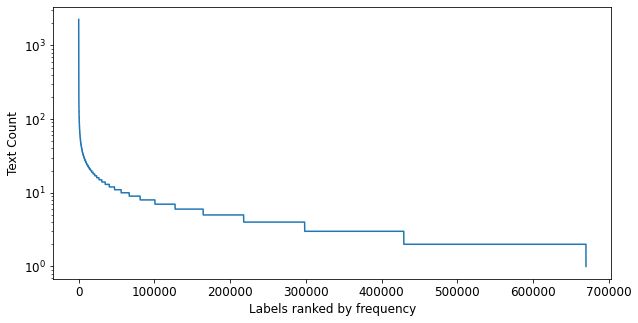

In [91]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1,1,1)
ax.plot(ranked_freqs)
ax.set_xlabel('Labels ranked by frequency')
ax.set_ylabel('Text Count')
ax.set_yscale('log');

#### Check #4: Computing the min label freq for each text

In [70]:
df_copy.head(10)

,text,labels,is_valid,label_count,min_code_freq,max_code_freq,90pct_code_freq
0,"Methodical Bible study: A new approach to hermeneutics /SEP/ Methodical Bible study: A new approach to hermeneutics. Inductive study compares related Bible texts in order to let the Bible interpret itself, rather than approaching Scripture with predetermined notions of what it will say. Dr. Trainas Methodical Bible Study was not intended to be the last word in inductive Bible study; but since its first publication in 1952, it has become a foundational text in this field. Christian colleges and seminaries have made it required reading for beginning Bible students, while many churches have...","34141,119299,126600,128716,187372,218742",False,6,2,29,25.5
1,"Southeastern Mills Roast Beef Gravy Mix, 4.5-Ounce Packages (Pack of 24) /SEP/ Southeastern Mills Roast Beef Gravy Mix, 4.5-Ounce Packages (Pack of 24). Makes 3-1/2 cups. Down home taste. Makes hearty beef stew base.","465536,465553,615429",False,3,2,3,3.0
2,"MMF Industries 24-Key Portable Zippered Key Case (201502417) /SEP/ MMF Industries 24-Key Portable Zippered Key Case (201502417). The MMF Industries 201502417 24-Key Portable Zippered Key Case is an attractive burgundy-colored leather-like vinyl case with brass corners and looks like a portfolio. Its easy-slide zipper keeps keys enclosed, and a hook-and-loop fastener strips keep keys securely in place. Key tags are included.\tZippered key case offers a portable alternative to metal wall key cabinets. Included key tags are backed by hook-and-loop closures. Easy slide zipper keeps keys enclos...",393828,False,1,2,2,2.0
3,"Hoover the Fishing President /SEP/ Hoover the Fishing President. Hal Elliott Wert has spent years researching Herbert Hoover, Franklin Roosevelt, and Harry Truman. He holds a Ph.D. from the University of Kansas and currently teaches at the Kansas City Art Institute.","167614,223686",False,2,4,4,4.0
4,"GeoPuzzle U.S.A. and Canada - Educational Geography Jigsaw Puzzle (69 pcs) /SEP/ GeoPuzzle U.S.A. and Canada - Educational Geography Jigsaw Puzzle (69 pcs). GeoPuzzles are jigsaw puzzles that make learning world geography fun. The pieces of a GeoPuzzle are shaped like individual countries, so children learn as they put the puzzle together. Award-winning Geopuzzles help to build fine motor, cognitive, language, and problem-solving skills, and are a great introduction to world geography for children 4 and up. Designed by an art professor, jumbo sized and brightly colored GeoPuzzles are avail...","480528,480530,480532,485144,485146,598793",False,6,5,10,8.5
5,"Amazon.com: Paul Fredrick Men's Cotton Pinpoint Oxford Straight Collar Dress Shirt: Clothing /SEP/ Amazon.com: Paul Fredrick Men's Cotton Pinpoint Oxford Straight Collar Dress Shirt: Clothing. Pinpoint Oxford Cotton. Traditional Straight Collar, 1/4 Topstitched. Button Cuffs, 1/4 Topstitched. Embedded Collar Stay. Regular, Big and Tall. Top Center Placket. Split Yoke. Single Front Rounded Pocket. Machine Wash Or Dry Clean. Imported. * Big and Tall Sizes - addl $5.00","516790,567615,670034",False,3,256,1214,1141.2
6,"Darkest Fear : A Myron Bolitar Novel /SEP/ Darkest Fear : A Myron Bolitar Novel. Myron Bolitar's father's recent heart attack brings Myron smack into a midlife encounter with issues of adulthood and mortality. And if that's not enough to turn his life upside down, the reappearance of his first serious girlfriend is. The basketball star turned sports agent, who does a little detecting when business is slow, is saddened by the news that Emily Downing's 13-year-old son is dying and desperately needs a bone marrow transplant; even if she did leave him for the man who destroyed his basketball c...","50442,50516,50647,50672,50680,662538",False,6,2,3,2.5
7,"In Debt We Trust (2007) /SEP/ In Debt We Trust (2007). Just a few decades ago, owing more money than you had in your bank account was the exception, not the rule. Yet, in the last 10 years, consumer debt has doubled and,

In [92]:
df_copy['min_code_freq'] = df_copy.apply(
    lambda row: min([lbl_freqs[lbl] for lbl in row.labels.split(',')]), axis=1)

In [93]:
df_copy['max_code_freq'] = df_copy.apply(
    lambda row: max([lbl_freqs[lbl] for lbl in row.labels.split(',')]), axis=1)

In [94]:
df_copy['90pct_code_freq'] = df_copy.apply(
    lambda row: np.percentile([lbl_freqs[lbl] for lbl in row.labels.split(',')], 90), axis=1)

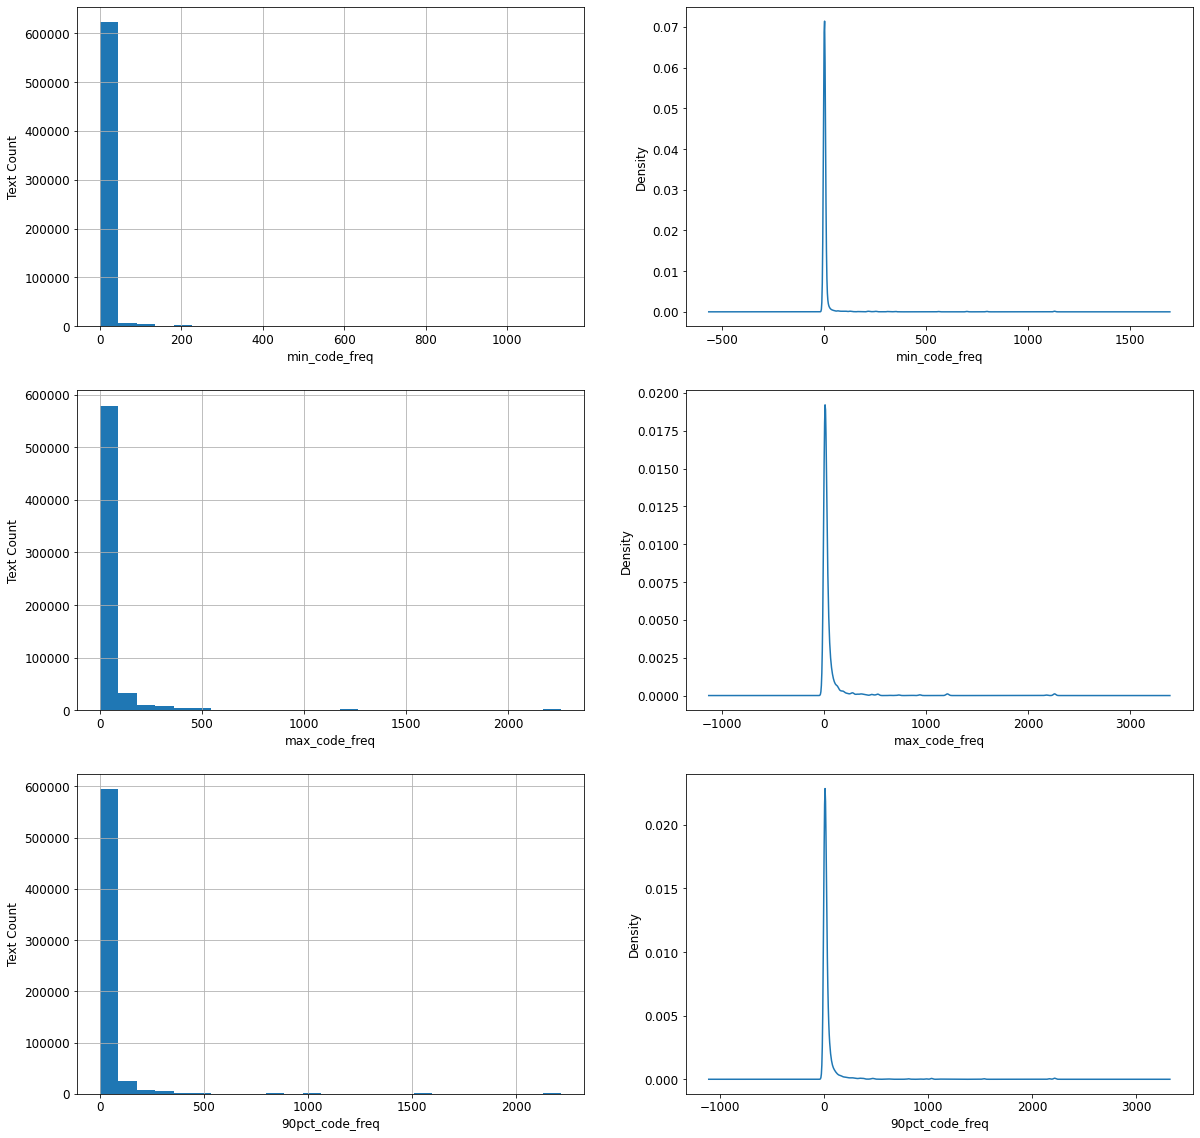

In [95]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(20,20))

for freq, axis in zip(['min_code_freq', 'max_code_freq', '90pct_code_freq'], axes):
    df_copy[freq].hist(ax=axis[0], bins=25)
    axis[0].set_xlabel(freq)
    axis[0].set_ylabel('Text Count')
    df_copy[freq].plot.density(ax=axis[1])
    axis[1].set_xlabel(freq)
    

In [96]:
min_code_freqs = Counter(df_copy['min_code_freq'])
max_code_freqs = Counter(df_copy['max_code_freq'])
nintypct_code_freqs = Counter(df_copy['90pct_code_freq'])

In [97]:
total_notes = L(min_code_freqs.values()).sum()
total_notes

643474

In [98]:
for kmin in min_code_freqs:
    min_code_freqs[kmin] = (min_code_freqs[kmin]/total_notes) * 100
    
for kmax in max_code_freqs:
    max_code_freqs[kmax] = (max_code_freqs[kmax]/total_notes) * 100
    
for k90pct in nintypct_code_freqs:
    nintypct_code_freqs[k90pct] = (nintypct_code_freqs[k90pct]/total_notes) * 100

In [99]:
min_code_freqs = dict(sorted(min_code_freqs.items(), key=lambda item: item[0]))
max_code_freqs = dict(sorted(max_code_freqs.items(), key=lambda item: item[0]))
nintypct_code_freqs = dict(sorted(nintypct_code_freqs.items(), key=lambda item: item[0]))

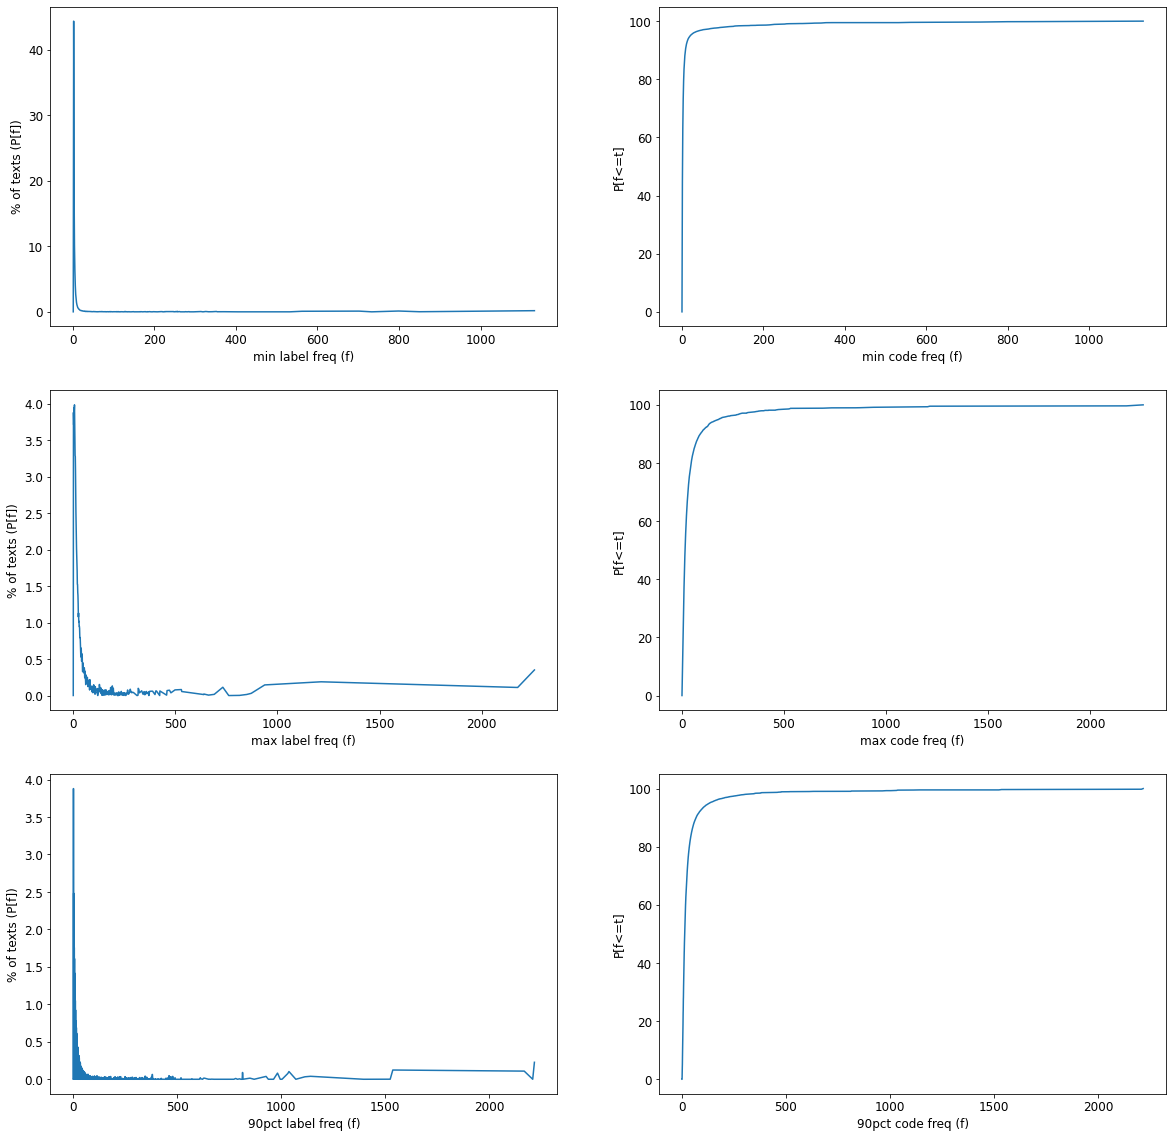

In [100]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(20,20))

for axis, freq_dict, label in zip(axes, (min_code_freqs, max_code_freqs, nintypct_code_freqs), ('min', 'max', '90pct')):
    axis[0].plot(freq_dict.keys(), freq_dict.values())
    axis[0].set_xlabel(f"{label} label freq (f)")
    axis[0].set_ylabel("% of texts (P[f])");
    
    axis[1].plot(freq_dict.keys(), np.cumsum(list(freq_dict.values())))
    axis[1].set_xlabel(f"{label} code freq (f)")
    axis[1].set_ylabel("P[f<=t]");

### Steps for creating the classifier `DataLoaders` using fastai's `Transforms`:

#### 1. train/valid `splitter`:

Okay, based on the `is_valid` column of our Dataframe, let's create a splitter:

In [21]:
def splitter(df):
    train = df.index[~df['is_valid']].tolist()
    valid = df.index[df['is_valid']].to_list()
    return train, valid

Let's check the train/valid split

In [22]:
splits = [train, valid] = splitter(df)
L(splits[0]), L(splits[1])

((#14839) [0,1,2,3,4,5,6,7,8,9...],
 (#979) [26,44,60,77,82,108,115,124,154,159...])

#### 2. Making the `Datasets` object:

**Crucial:** We need the vocab of the language model so that we can make sure we use the same correspondence of token to index. Otherwise, the embeddings we learned in our fine-tuned language model won't make any sense to our classifier model, and the fine-tuning won't be of any use. So we need to pass the `lm_vocab` to the `Numericalize` transform:

So let's load the vocab of the language model:

In [23]:
lm_vocab = torch.load(dls_lm_vocab_path)
lm_vocab_r = torch.load(dls_lm_vocab_r_path)

In [24]:
L(lm_vocab), L(lm_vocab_r)

((#57376) ['xxunk','xxpad','xxbos','xxeos','xxfld','xxrep','xxwrep','xxup','xxmaj','the'...],
 (#57376) ['xxunk','xxpad','xxbos','xxeos','xxfld','xxrep','xxwrep','xxup','xxmaj','the'...])

In [25]:
x_tfms = [Tokenizer.from_df('text'), attrgetter("text"), Numericalize(vocab=lm_vocab)]
x_tfms_r = [Tokenizer.from_df('text', ), attrgetter("text"), Numericalize(vocab=lm_vocab), reverse_text]
y_tfms = [ColReader('labels', label_delim=';'), MultiCategorize(vocab=lbls), OneHotEncode()]
tfms = [x_tfms, y_tfms]
tfms_r = [x_tfms_r, y_tfms]

In [26]:
dsets = Datasets(df, tfms, splits=splits)

In [109]:
dsets_r = Datasets(df, tfms_r, splits=splits)

Let's now check if our `Datasets` got created alright:

In [27]:
len(dsets.train), len(dsets.valid)

(14839, 979)

Let's check a random data point:

In [33]:
idx = random.randint(0, len(dsets))
x, x_r = dsets.train[idx], dsets_r.train[idx]

In [122]:
dsets.decode(x)

('xxbos admission date discharge date date of birth sex f service neurology allergies patient recorded as having no known allergies to drugs attending last name namepattern1 chief complaint intraparenchymal hemorrhage major surgical or invasive procedure arrived intubated history of present illness ms known lastname is a year old right handed woman with a past medical history including tia memory loss and right retinal detachment who presents from hospital3 hospital with intraparenchymal hemorrhage the patient s family explains that ms known lastname was in her usual state of health on at about pm when her son in law stopped by to help administer some eye drops the family next returned at about pm and found the patient unresponsive and lying on the couch with her living doctor first name in slight disarray her son in law recalls tapping her and calling her name without appreciable response initially however he subsequently found that she was able to look straight at him and follow his 

In [124]:
dsets.show(x)

xxbos admission date discharge date date of birth sex f service neurology allergies patient recorded as having no known allergies to drugs attending last name namepattern1 chief complaint intraparenchymal hemorrhage major surgical or invasive procedure arrived intubated history of present illness ms known lastname is a year old right handed woman with a past medical history including tia memory loss and right retinal detachment who presents from hospital3 hospital with intraparenchymal hemorrhage the patient s family explains that ms known lastname was in her usual state of health on at about pm when her son in law stopped by to help administer some eye drops the family next returned at about pm and found the patient unresponsive and lying on the couch with her living doctor first name in slight disarray her son in law recalls tapping her and calling her name without appreciable response initially however he subsequently found that she was able to look straight at him and follow his re

If we just want to decode the one-hot encoded dependent variable:

In [34]:
_ind, _dep = x
_lbl = dsets.tfms[1].decode(_dep)

Let's extract the `MultiCategorize` transform applied by `dsets` on the dependent variable so that we can apply it ourselves:

In [36]:
tfm_cat = dsets.tfms[1][1]
test_eq(str(tfm_cat.__class__), "<class 'fastai.data.transforms.MultiCategorize'>")

`vocab` attribute of the `MultiCategorize` transform stores the category vocabulary. If it was specified from outside (in this case it was) then the `MultiCategorize` transform will not sort the vocabulary otherwise it will.

In [45]:
test_eq(lbls, tfm_cat.vocab)
test_ne(lbls, sorted(tfm_cat.vocab))

In [46]:
test_eq(str(_lbl.__class__), "<class 'fastai.data.transforms.MultiCategory'>")
test_eq(tfm_cat(_lbl), TensorMultiCategory([lbls.index(o) for o in _lbl]))
test_eq(tfm_cat.decode(tfm_cat(_lbl)), _lbl)

Let's check the reverse:

In [73]:
dsets_r.decode(x_r)

('by completed expired instructions followup expired instructions discharge expired condition discharge expired diagnosis discharge expired disposition discharge expired medications discharge folate abilify ppi proscar doxazosin klonopin depakote aricept lisinopril simvastatin aggrenox admission on medications resolved thrombocytopenia statin blocker beta continue negative ces resolved changes ecg intervene not will following neurosurgery shunt csf of site the at head the on mass xxunk sedation fentanyl and effect good with olanzapine dose low prn on now agitated zyprexa escitalopram xxunk on psych cva hemorrhagic pain pt spare to suctioning holding fentanyl with sedation increased on cmo to go to decided has family ventilated care mouth on yeast and flu h on sputum positive serratia for cipro continue on zosyn and vanc d c d intubated now sputum positive xxunk and serratia aspiration likely pneumonia autospy declined family on at pneumonia aspiration and stroke hemorrhagic failure res

In [74]:
dsets_r.show(x_r)

by completed expired instructions followup expired instructions discharge expired condition discharge expired diagnosis discharge expired disposition discharge expired medications discharge folate abilify ppi proscar doxazosin klonopin depakote aricept lisinopril simvastatin aggrenox admission on medications resolved thrombocytopenia statin blocker beta continue negative ces resolved changes ecg intervene not will following neurosurgery shunt csf of site the at head the on mass xxunk sedation fentanyl and effect good with olanzapine dose low prn on now agitated zyprexa escitalopram xxunk on psych cva hemorrhagic pain pt spare to suctioning holding fentanyl with sedation increased on cmo to go to decided has family ventilated care mouth on yeast and flu h on sputum positive serratia for cipro continue on zosyn and vanc d c d intubated now sputum positive xxunk and serratia aspiration likely pneumonia autospy declined family on at pneumonia aspiration and stroke hemorrhagic failure respi

Looks fine!

#### Training a Collaborative Filtering Model to Learn the Label Embeddings

We want to train a *collaborative filtering* model on the `lm_vocab`-`lbls` matrix, where each entry of the matrix is the number of times a particular token in the vocab has co-occurred in the dataset.

In [6]:
dsets = torch.load('dsets.pkl')

In [7]:
lm_vocab = torch.load(dls_lm_vocab_path)

In [8]:
lbls = dsets.vocab[1]

In [9]:
L(lm_vocab)

(#57376) ['xxunk','xxpad','xxbos','xxeos','xxfld','xxrep','xxwrep','xxup','xxmaj','the'...]

In [10]:
L(lbls)

(#6586) ['431','507.0','518.81','112.0','287.4','401.9','427.89','600.00','272.4','300.4'...]

The script `tf.py` computes the term frequencies.

In [15]:
# %less tf.py

In [16]:
# %run tf.py

100%|███████████████████████████████████████████████████████████████████████████████████████████████| 14839/14839 [03:15<00:00, 75.78it/s]


time = 200.03412199020386


At this point we have the term frequencies (in a `Counter` dictionary called `tf.pkl`), so let's load it up and plot the distribution:

In [18]:
# tf is a word frequency dict
tf = torch.load('tf.pkl')

In [19]:
len(tf)

49486

In [20]:
tf.most_common(10)

[('the', 589298),
 ('and', 509523),
 ('of', 430972),
 ('to', 427540),
 ('was', 406389),
 ('with', 303270),
 ('a', 291702),
 ('on', 270952),
 ('in', 232700),
 ('for', 219395)]

In [21]:
freqs = list(tf.values())

In [22]:
np.max(freqs), np.min(freqs), np.mean(freqs), np.median(freqs), np.std(freqs)

(589298, 1, 453.75633512508585, 5.0, 6544.621037461553)

Let's plot a histogram of the term frequencies:

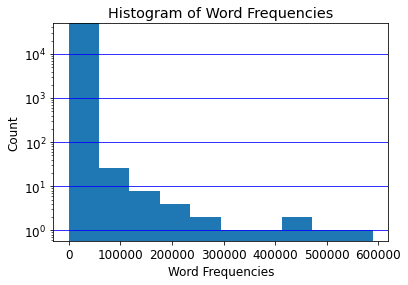

In [23]:
n, bins, pathches = plt.hist(freqs)
plt.grid(axis='y', color='b')
plt.yscale('log')
plt.xlabel('Word Frequencies')
plt.ylabel('Count')
maxfreq = n.max()
plt.ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)
plt.title('Histogram of Word Frequencies');

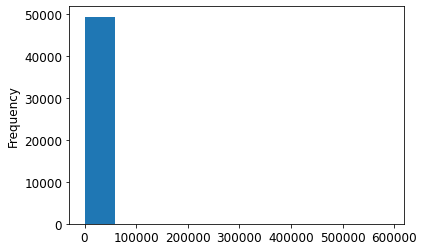

In [25]:
pd.Series(freqs).plot.hist();

<AxesSubplot:ylabel='Density'>

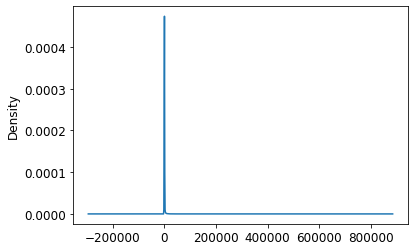

In [26]:
pd.Series(freqs).plot.density()

In [125]:
# plt.hist(x=freqs, bins=np.logspace(1,20, 1000))
# plt.xscale('log')
# plt.yscale('log')

In [ ]:
np.logspace(np.log10(0.1),np.log10(1.0), 50)

array([0.1       , 0.10481131, 0.10985411, 0.11513954, 0.12067926, 0.12648552, 0.13257114, 0.13894955, 0.14563485, 0.1526418 , 0.15998587, 0.16768329, 0.17575106, 0.184207  , 0.19306977, 0.20235896,
       0.21209509, 0.22229965, 0.23299518, 0.24420531, 0.25595479, 0.26826958, 0.28117687, 0.29470517, 0.30888436, 0.32374575, 0.33932218, 0.35564803, 0.37275937, 0.39069399, 0.40949151, 0.42919343,
       0.44984327, 0.47148664, 0.49417134, 0.51794747, 0.54286754, 0.5689866 , 0.59636233, 0.62505519, 0.65512856, 0.68664885, 0.71968567, 0.75431201, 0.79060432, 0.82864277, 0.86851137, 0.91029818,
       0.95409548, 1.        ])

In [79]:
np.log10(0.1), np.log10(1.0)

(-1.0, 0.0)

In [83]:
np.logspace(0, 1, 50)

array([ 1.        ,  1.04811313,  1.09854114,  1.1513954 ,  1.20679264,  1.26485522,  1.32571137,  1.38949549,  1.45634848,  1.52641797,  1.59985872,  1.67683294,  1.75751062,  1.84206997,
        1.93069773,  2.02358965,  2.12095089,  2.22299648,  2.32995181,  2.44205309,  2.55954792,  2.6826958 ,  2.8117687 ,  2.9470517 ,  3.0888436 ,  3.23745754,  3.39322177,  3.55648031,
        3.72759372,  3.90693994,  4.09491506,  4.29193426,  4.49843267,  4.71486636,  4.94171336,  5.17947468,  5.42867544,  5.68986603,  5.96362332,  6.25055193,  6.55128557,  6.86648845,
        7.19685673,  7.54312006,  7.90604321,  8.28642773,  8.68511374,  9.10298178,  9.54095476, 10.        ])

Let's create a dataframe with three columns 'token', 'label', and the corresponding 'frequency':

In [191]:
# df_lbl = pd.DataFrame(itertools.product(vocab, lbls), columns=['token', 'label'])
# df_lbl.to_feather(path/'df_lbl.pkl')

In [24]:
df_lbl = pd.read_feather(path/'df_lbl.pkl')

In [25]:
len(df_lbl)

325914796

In [26]:
df_lbl.head()

,token,label
0,xxbos,431
1,xxbos,507.0
2,xxbos,518.81
3,xxbos,112.0
4,xxbos,287.4


Now to add the third column of 'frequency' we need to compute it from the training data. The script `toklbl.py` computes the frequencies of each token label pair and stores it in the file `tlfq.pkl` (for term-label-frequencies):

In [47]:
# %less toklbl.py

In [44]:
# %run 'toklbl.py'

In [27]:
tlfq = torch.load('tlfq.pkl')

In [28]:
len(tlfq)

18670317

In [29]:
tlfq.most_common(1000)[:-20:-1]

[(('have', '401.9'), 17089),
 (('and', '34.04'), 17091),
 (('last', '96.6'), 17108),
 (('was', '99.83'), 17144),
 (('there', '38.93'), 17166),
 (('an', '38.93'), 17174),
 (('her', '599.0'), 17205),
 (('and', '263.9'), 17206),
 (('date', '38.93'), 17211),
 (('mg', '995.92'), 17229),
 (('and', '707.03'), 17247),
 (('as', '99.04'), 17257),
 (('mg', '39.95'), 17271),
 (('on', '584.5'), 17272),
 (('with', '45.13'), 17275),
 (('the', '707.03'), 17286),
 (('for', '403.90'), 17293),
 (('in', '88.72'), 17308),
 (('was', '99.07'), 17310)]

In [30]:
df_lbl['frequency'] = 0

In [31]:
df_lbl.head()

,token,label,frequency
0,xxbos,431,0
1,xxbos,507.0,0
2,xxbos,518.81,0
3,xxbos,112.0,0
4,xxbos,287.4,0


In [35]:
cond1 = (df_lbl['token'] == 'xxbos')
cond2 = df_lbl['label'] == '518.81'
df_tmp = df_lbl[cond1]
df_tmp2 = df_tmp[cond2]
df_tmp2['frequency']

/tmp/ipykernel_1534/3748863341.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tmp2 = df_tmp[cond2]


2    0
Name: frequency, dtype: int64

In [ ]:
df_lbl.at()

In [ ]:
for tok, lbl in itertools.islice(tlfq, 10):
    df_lbl[(df_lbl.token == tok) & (df_lbl.label == lbl)]['frequency'] = tlfq[(tok,lbl)]

#### 3. Making the `DataLoaders` object:

We need to pick the sequence length and the batch size:

In [28]:
bs, sl = 16, 72

We will use the `dl_type` argument of the `DataLoaders`. The purpose is to tell `DataLoaders` to use `SortedDL` class of the `DataLoader`, and not the usual one. `SortedDL` constructs batches by putting samples of roughly the same lengths into batches.

In [29]:
dl_type = partial(SortedDL, shuffle=True)

**Crucial:** 
- We will use **`pad_input_chunk`** because our encoder `AWD_LSTM` will be wrapped inside `SentenceEncoder`. 
- A `SenetenceEncoder` expects that all the documents are padded, 
- with most of the padding at the beginning of the document, with each sequence beginning at a round multiple of bptt
- and the rest of the padding at the end.

In [30]:
dls_clas = dsets.dataloaders(bs=bs, seq_len=sl, 
                             dl_type=dl_type,
                             before_batch=pad_input_chunk)

For the reverse:

In [77]:
dls_clas_r = dsets_r.dataloaders(bs=bs, seq_len=sl,
                                 dl_type=dl_type,
                                 before_batch=pad_input_chunk)

Creating the `DataLoaders` object takes considerable amount of time, so let's save it:

In [44]:
# dls_clas_path_eight =  path_model/(file_prefix+'_dls_clas_8.pkl')
# dls_clas_path_eight

In [45]:
# torch.save(dls_clas, dls_clas_path_eight)

In [46]:
torch.save(dls_clas, dls_clas_path)

In [78]:
torch.save(dls_clas_r, dls_clas_r_path)

Let's take a look at the data:

In [31]:
dls_clas.show_batch(max_n=3)

/home/deb/miniconda3/lib/python3.9/site-packages/fastai/torch_core.py:476: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ax = ax.append(pd.Series({label: o}))
/home/deb/miniconda3/lib/python3.9/site-packages/fastai/torch_core.py:476: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ax = ax.append(pd.Series({label: o}))
/home/deb/miniconda3/lib/python3.9/site-packages/fastai/torch_core.py:476: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ax = ax.append(pd.Series({label: o}))
/home/deb/miniconda3/lib/python3.9/site-packages/fastai/torch_core.py:476: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ax = ax.append(pd.Series({label: o}))
/hom

,text,None
0,xxbos admission date discharge date date of birth sex f service surgery allergies patient recorded as having no known allergies to drugs attending first name3 lf chief complaint severe pancreatitis major surgical or invasive procedure picc placement percutaneous tracheostomy history of present illness this is a year old female who woke up the morning of with severe periumbilical abdominal pain nausea and vomitting she vomitted times and reports no blood her pain became epigastric in nature but did not radiate stayed in midline of her abdomen she reports normal bowel movements no diarrhea and no ruq pain she had been in her usoh before this time and denies any other concerns she presented to hospital3 that day and her vitals there were significant for low grade temp blood pressure was stable in the 120s 140s and persistently tachycardic in the 120s her alt was ast t bili alk phos amylase,518.81;401.9;427.89;96.04;96.72;99.15;96.6;38.91;38.93;99.04;276.2;276.51;584.9;511.9;428.0;599.0;285.9;33.24;31.1;560.1;789.5;577.0;519.1;482.83;995.94;89.62;V11.3;579.9;574.21;577.2;V63.2
1,xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad,272.4;96.71;96.04;93.9;428.0;585.9;733.00;493.22;403.90;428.31;725;280.9;96.05;V15.81;350.1;465.9
2,xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad,427.89;96.6;43.19;275.3;276.2;89.19;285.29;008.45;38.97;288.60;996.1;788.30;780.60;345.3;783.7;742.9;345.81;343.2;754.2;315.8;280.8;306.8


In [79]:
dls_clas_r.show_batch(max_n=3)

/home/deb/miniconda3/lib/python3.9/site-packages/fastai/torch_core.py:476: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ax = ax.append(pd.Series({label: o}))
/home/deb/miniconda3/lib/python3.9/site-packages/fastai/torch_core.py:476: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ax = ax.append(pd.Series({label: o}))
/home/deb/miniconda3/lib/python3.9/site-packages/fastai/torch_core.py:476: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ax = ax.append(pd.Series({label: o}))
/home/deb/miniconda3/lib/python3.9/site-packages/fastai/torch_core.py:476: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ax = ax.append(pd.Series({label: o}))
/hom

,text,None
0,by completed time date unit hemodialysis schedule dialysis nameis name10 provider time date phone md nameis name11 nameis name10 provider garage name ward hospital parking best west campus un location name unit hospital lm building fax telephone md namepattern1 name last namepattern1 name4 first with am at tuesday when center transplant department garage name ward hospital parking best west campus un location namepattern1 name last bldg name ward hospital lm building fax telephone md namepattern1 name last pattern1 name name11 first with am at monday when center transplant department xray chest a for center clinical name ward hospital the of un location the on department radiology the to appointment your to prior minutes report please garage name ward hospital parking best east campus un location ctr clinical name ward hospital sc building md md name8 md name6 with pm at thursday when oncology hematology department instructions followup coumadin on placed,272.4;96.72;99.15;96.6;33.1;E878.8;276.2;34.91;998.59;785.52;995.92;530.81;585.6;39.95;038.9;486;276.69;33.24;276.0;31.1;996.81;38.95;707.03;38.97;519.19;933.1;434.11;V42.83;997.79;33.22;518.51;336.1;531.50;998.30;997.02;453.86;569.81;707.23;250.61;356.9;V45.11;31.79;31.74;33.48;44.41
1,hospital the in done work lab of results the for up follow to and medication thyroid the also and levels calcium high the discuss to appointment an schedule to fax telephone call stitle name stitle name last dr endocrinologist your with appointment an make please time date fax telephone phone md namepattern4 name last pattern1 name name11 first provider time date fax telephone phone scc xray nameis name10 provider fax telephone call please call not does someone if appointment an make to you calling be should clinic their from someone diease parkinsons your of treatment regarding neurology with up follow please eosinophilia for and neck your in node lymph the up follow to days within stitle name last dr with up follow to appointment an make please instructions followup tube peg the thru given be should medications your all infections lung and aspiration of risk the avoid to mouth by,507.0;518.81;401.9;96.71;96.04;38.91;99.04;584.9;428.0;585.9;V10.87;599.0;715.90;311;296.80;733.00;285.29;332.0;054.9;808.0;805.6;808.2;244.0;275.42;785.6;530.5;750.3;787.2;288.3;494.0;V55.1;V02.59;E885.9;97.02
2,xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad,518.81;272.4;530.81;584.9;403.91;410.71;588.81;428.23;428.0;39.95;414.01;V58.67;285.21;998.12;V45.82;37.22;88.56;V43.65;733.00;416.8;38.95;276.8;276.1;250.40;E879.8;276.50;288.60;274.9;276.3;493.90;88.53;564.00;724.2;414.8;997.2;414.04;447.0;442.3;585.5;716.96;V16.0;39.52;99.29;88.77


#### 4. (Optional) Making the `DataLoaders` using fastai's `DataBlock` API:

It's worth mentioning here that all the steps we performed to create the `DataLoaders` can be packaged together using fastai's `DataBlock` API. 

In [24]:
dblock = DataBlock(
        blocks = (TextBlock.from_df('text', seq_len=sl, vocab=lm_vocab), MultiCategoryBlock(vocab=lbls)),
        get_x = ColReader('text'),
        get_y = ColReader('labels', label_delim=';'),
        splitter = splitter,
        dl_type = dl_type,
)

In [25]:
dls_clas = dblock.dataloaders(df, bs=bs, before_batch=pad_input_chunk)

In [27]:
dls_clas.show_batch(max_n=5)

/home/deb/miniconda3/lib/python3.9/site-packages/fastai/torch_core.py:476: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ax = ax.append(pd.Series({label: o}))
/home/deb/miniconda3/lib/python3.9/site-packages/fastai/torch_core.py:476: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ax = ax.append(pd.Series({label: o}))
/home/deb/miniconda3/lib/python3.9/site-packages/fastai/torch_core.py:476: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ax = ax.append(pd.Series({label: o}))
/home/deb/miniconda3/lib/python3.9/site-packages/fastai/torch_core.py:476: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ax = ax.append(pd.Series({label: o}))
/hom

,text,None
0,xxbos admission date discharge date date of birth sex m service cardiothoracic allergies codeine percocet sulfa sulfonamide antibiotics attending first name3 lf chief complaint dyspnea and coughing major surgical or invasive procedure right thoracotomy and intrathoracic tracheoplasty with mesh right mainstem bronchus and bronchus intermedius bronchoplasty with mesh left mainstem bronchus bronchoplasty with mesh bronchoscopy with bronchoalveolar lavage doctor last name flexible bronchoscopy doctor last name cricothyroidotomy doctor last name revision of tracheostomy tube to xl t shiley doctor last name flexible bronchoscopy with bronchoalveolar lavage doctor last name exploratory laparotomy with closure of perforated gastric ulcer with modified location un patch doctor last name left ij tunnelled hd catheter right basilic dl picc history of present illness 52 m with a history of diabetes kidney transplant in and pancreas transplant in colon cancer and tracheobronchomalacia status post y stent placement removed for excessive granulation tissue with a subsequent hospital,272.4;96.72;99.15;96.6;33.1;E878.8;276.2;34.91;998.59;785.52;995.92;530.81;585.6;39.95;038.9;486;276.69;33.24;276.0;31.1;996.81;38.95;707.03;38.97;519.19;933.1;434.11;V42.83;997.79;33.22;518.51;336.1;531.50;998.30;997.02;453.86;569.81;707.23;250.61;356.9;V45.11;31.79;31.74;33.48;44.41
1,xxbos admission date discharge date date of birth sex f service medicine allergies tetracyclines zinc attending first name3 lf chief complaint fall major surgical or invasive procedure none history of present illness year old f with xxunk s syndrome recurrent aspiration pna htn who presents s p fall she fell yesterday while trying to get up from bed and was put back to bed by her home health aid today she fell again and her aid dragged her to bed and called ems some head and l hip trauma no loc in the ed she received mso4 mg iv for pain her c spine was cleared head ct and hip films were negative fall was thought to be mechanical and social work was consulted re question of elder abuse neglect at midnight pt spiked to rectal received tylenol cxr and ua negative she was admitted for observation and placement of,507.0;518.81;401.9;96.71;96.04;38.91;99.04;584.9;428.0;585.9;V10.87;599.0;715.90;311;296.80;733.00;285.29;332.0;054.9;808.0;805.6;808.2;244.0;275.42;785.6;530.5;750.3;787.2;288.3;494.0;V55.1;V02.59;E885.9;97.02
2,xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad,518.81;272.4;530.81;584.9;403.91;410.71;588.81;428.23;428.0;39.95;414.01;V58.67;285.21;998.12;V45.82;37.22;88.56;V43.65;733.00;416.8;38.95;276.8;276.1;250.40;E879.8;276.50;288.60;274.9;276.3;493.90;88.53;564.00;724.2;414.8;997.2;414.04;447.0;442.3;585.5;716.96;V16.0;39.52;99.29;88.77
3,xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxp

## `Learner` for Multi-Label Classifier Fine-Tuning 

In [168]:
dls_clas = torch.load(dls_clas_path)

In [169]:
# dls_clas_r = torch.load(dls_clas_r_path)

In [170]:
# dls_clas.bs, dls_clas_r.bs

In [32]:
learn = text_classifier_learner(dls_clas, AWD_LSTM, drop_mult=0.1, max_len=72*40, metrics=partial(PrecisionK, k=15)).to_fp16()

In [ ]:
# learn_r = text_classifier_learner(dls_clas_r, AWD_LSTM, drop_mult=0.1, max_len=72*40, metrics=partial(PrecisionK, k=15)).to_fp16()

In [13]:
import inspect
print(inspect.getsource(learn.model[-1].__class__))

class LabelAttentionClassifier3(Module):
    initrange=0.1
    def __init__(self, dims, ps, bptt, y_range=None):
        self.fts = dims[0]
        self.lbs = dims[-1]

        # ps = 0.1 # deb
        self.layers = LinBnDrop(self.lbs, ln=False, p=ps, act=None) # deb
        self.attn = XMLAttention(self.lbs, self.fts, 0.0)
        self.final_lin = nn.Linear(self.fts, self.lbs)
        init_default(self.final_lin,
                     func=partial(torch.nn.init.uniform_, a=-self.initrange, b=self.initrange))

    def forward(self, input):
        out, _ = input
        ctx = self.attn(out)
        x = self.layers(ctx)
        x = (self.final_lin.weight * ctx).sum(dim=2) + self.final_lin.bias

        return x, out, out



In [14]:
print(inspect.getsource(learn.model[-1].attn.__class__))

class XMLAttention(Module):
    "Compute label specific attention weights for each token in a sequence"
    def __init__(self, n_lbs, emb_sz, embed_p):
         store_attr('n_lbs,emb_sz,embed_p')
         self.lbs_emb = nn.Embedding(n_lbs, emb_sz)
         self.lbs_emb_dp = EmbeddingDropout(self.lbs_emb, embed_p)
         self.lbs_emb.weight.data.normal_(0, 0.01)
         self.input_dp = RNNDropout(0.02)

    def forward(self, x):
        lbs_emb = self.lbs_emb(torch.arange(self.n_lbs, device=x.device))
        # x_dp = self.input_dp(x)
        attn_wgts = F.softmax(x @ lbs_emb.transpose(0,1), dim=1)
        return attn_wgts.transpose(1,2) @ x



In [33]:
learn = learn.load_encoder(file_prefix+'_lm_finetuned')

In [32]:
# learn_r = learn_r.load_encoder(file_prefix+'_lm_finetuned_r')

## Fine-Tuning the Classifier 

The last step (yes, the madness will end soon) is to train with:
- *discriminative learning rates*: define here
- *gradual unfreezing*: define here

(0.33113112449646,
 0.0831763744354248,
 0.0030199517495930195,
 0.2089296132326126)

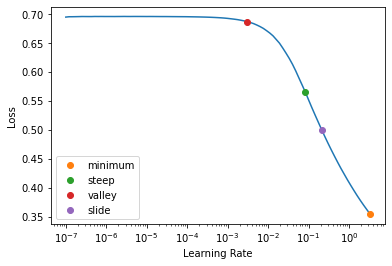

In [34]:
lr_min, lr_steep, lr_valley, lr_slide = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))
lr_min, lr_steep, lr_valley, lr_slide

In [35]:
learn.fit_one_cycle(2, lr_max=lr_min, moms=(0.8,0.7,0.8), wd=0.1, 
cbs=SaveModelCallback(monitor='PrecisionK', fname=file_prefix+'_clas'))

epoch,train_loss,valid_loss,PrecisionK,time
0,0.010431,0.012475,0.300919,06:36
1,0.008943,0.010792,0.432823,06:36


Better model found at epoch 0 with PrecisionK value: 0.3009193054136874.
Better model found at epoch 1 with PrecisionK value: 0.43282260810350703.


In [ ]:
learn.fit_one_cycle(1, lr_max=lr_min, moms=(0.8,0.7,0.8), wd=0.1)

epoch,train_loss,valid_loss,PrecisionK,time
0,0.008764,0.010205,0.438134,06:18


This was the result after just three epochs. Now let's unfreeze the last two layers and do discriminative training:  

Now we will pass -2 to `freeze_to` to freeze all except the last two parameter groups:

In [228]:
learn.freeze_to(-2)

In [229]:
learn.fit_one_cycle(5, lr_max=1e-3, moms=(0.8,0.7,0.8), wd=0.1, 
                    cbs=SaveModelCallback(monitor='PrecisionK', fname=file_prefix+'_clas'))

epoch,train_loss,valid_loss,PrecisionK,time
0,0.041003,0.086084,0.243333,00:10
1,0.039440,0.083717,0.263333,00:09
2,0.038001,0.081930,0.266667,00:09
3,0.036703,0.082133,0.270000,00:09
4,0.035753,0.081931,0.263333,00:09


Better model found at epoch 0 with PrecisionK value: 0.24333333333333332.
Better model found at epoch 1 with PrecisionK value: 0.2633333333333333.
Better model found at epoch 2 with PrecisionK value: 0.2666666666666667.
Better model found at epoch 3 with PrecisionK value: 0.27.


Now we will unfreeze a bit more, recompute learning rate and continue training:

In [230]:
learn.freeze_to(-3)

In [231]:
learn.fit_one_cycle(6, lr_max=1e-3, moms=(0.8,0.7,0.8), wd=0.2,
                   cbs=SaveModelCallback(monitor='PrecisionK', fname=file_prefix+'_clas'))

epoch,train_loss,valid_loss,PrecisionK,time
0,0.034450,0.080546,0.270000,00:12
1,0.033531,0.080947,0.276667,00:12
2,0.032033,0.082211,0.293333,00:12
3,0.030677,0.081504,0.290000,00:12
4,0.029383,0.082039,0.290000,00:12
5,0.028305,0.081995,0.290000,00:12


Better model found at epoch 0 with PrecisionK value: 0.27.
Better model found at epoch 1 with PrecisionK value: 0.2766666666666667.
Better model found at epoch 2 with PrecisionK value: 0.29333333333333333.


In [17]:
learn.freeze_to(-4)

In [18]:
learn.fit_one_cycle(5, lr_max=1e-3, moms=(0.8,0.7,0.8), wd=0.2,
                   cbs=SaveModelCallback(monitor='PrecisionK', fname=file_prefix+'_clas'))

epoch,train_loss,valid_loss,PrecisionK,time
0,0.013988,0.029497,0.364211,01:14
1,0.014082,0.029875,0.367018,01:11
2,0.013557,0.029206,0.365614,01:13
3,0.013187,0.029233,0.367719,01:12
4,0.012697,0.029214,0.365614,01:13


Better model found at epoch 0 with valid_loss value: 0.029496705159544945.
Better model found at epoch 2 with valid_loss value: 0.029205653816461563.


Finally, we will unfreeze the whole model and perform training:

In [232]:
learn.unfreeze()

At this point, it starts overfitting too soon so either progressively increase `bs` or increase `wd` or decrease `lr_max`. Another way would be to drop out label embeddings, but for this one needs to carefully adjust the dropout prob. Same concept regarding dropping out the seqs nh.

In [233]:
learn.fit_one_cycle(20, lr_max=1e-4, moms=(0.8,0.7,0.8), wd=0.2,
                   cbs=SaveModelCallback(monitor='PrecisionK', fname=file_prefix+'_clas'))

epoch,train_loss,valid_loss,PrecisionK,time
0,0.028496,0.082081,0.293333,00:16
1,0.028203,0.081777,0.290000,00:16
2,0.028060,0.081804,0.283333,00:16
3,0.028077,0.081645,0.290000,00:16
4,0.027993,0.081489,0.286667,00:16
5,0.027839,0.081815,0.283333,00:16
6,0.027562,0.082060,0.286667,00:16
7,0.027314,0.082138,0.290000,00:16
8,0.027122,0.082166,0.290000,00:16
9,0.026927,0.082112,0.290000,00:16


Better model found at epoch 0 with PrecisionK value: 0.29333333333333333.


In [27]:
learn.fit_one_cycle(5, lr_max=1e-4, moms=(0.8,0.7,0.8), wd=0.2,
                   cbs=SaveModelCallback(monitor='PrecisionK', fname=file_prefix+'_clas'))

epoch,train_loss,valid_loss,PrecisionK,time
0,0.009093,0.028945,0.378246,01:17
1,0.009054,0.028963,0.376842,01:17
2,0.008918,0.028934,0.379649,01:17
3,0.008926,0.028949,0.381053,01:17
4,0.008689,0.028821,0.381053,01:16


Better model found at epoch 0 with PrecisionK value: 0.3782456140350878.
Better model found at epoch 2 with PrecisionK value: 0.3796491228070175.
Better model found at epoch 3 with PrecisionK value: 0.3810526315789473.
Better model found at epoch 4 with PrecisionK value: 0.3810526315789474.


In [33]:
learn.fit_one_cycle(15, lr_max=3.311311302240938e-05, moms=(0.8,0.7,0.8), wd=0.2,
                   cbs=SaveModelCallback(monitor='PrecisionK', fname=file_prefix+'_clas'))

epoch,train_loss,valid_loss,PrecisionK,time
0,0.009080,0.029099,0.380351,01:17
1,0.008792,0.028892,0.381053,01:18
2,0.008648,0.028956,0.381754,01:17
3,0.008792,0.028984,0.378947,01:17
4,0.008810,0.028974,0.381053,01:17
5,0.008679,0.028850,0.380351,01:17
6,0.008943,0.029143,0.379649,01:17
7,0.008815,0.029143,0.380351,01:17
8,0.008430,0.028840,0.380351,01:17
9,0.008651,0.029073,0.381053,01:17


Better model found at epoch 0 with PrecisionK value: 0.3803508771929824.
Better model found at epoch 1 with PrecisionK value: 0.3810526315789473.
Better model found at epoch 2 with PrecisionK value: 0.3817543859649123.


To save the model:

In [26]:
learn.save(file_prefix+'_clas')

Path('models/mimic3-9k_clas.pth')

To load the model:

In [27]:
learn = learn.load(file_prefix+'_clas')
learn.validate()

(#2) [0.08996422588825226,0.30333333333333334]

Or, validate manually (will be helpful to create an ensemble)

In [29]:
# learn.get_preds??

In [30]:
# learn.loss_func.activation??

In [28]:
preds, targs = learn.get_preds()
preds.shape, targs.shape

(torch.Size([20, 1271]), torch.Size([20, 1271]))

In [29]:
PrecisionK(preds, targs)

0.30333333333333334

To plot the train/valid loss and the metric over the course of training:

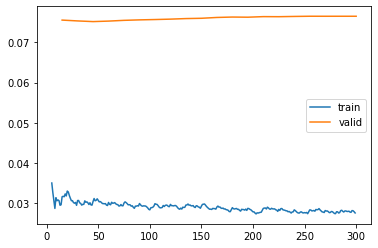

In [139]:
learn.recorder.plot_loss()

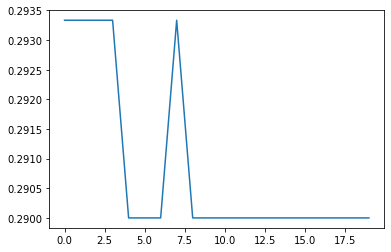

In [140]:
plt.plot(L(learn.recorder.values).itemgot(2));

## Fine-Tuning the Backward Classifier

(5.754399353463669e-07,
 1.5848931980144698e-06,
 0.001737800776027143,
 0.02290867641568184)

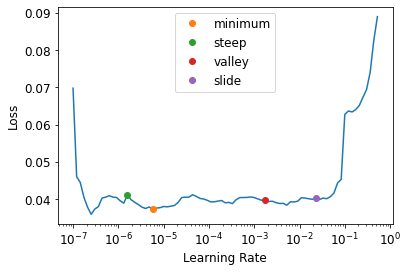

In [54]:
lr_min_r, lr_steep, lr_valley, lr_slide = learn_r.lr_find(suggest_funcs=(minimum, steep, valley, slide))
lr_min_r, lr_steep, lr_valley, lr_slide

In [45]:
learn_r.fit_one_cycle(2, lr_max=lr_min, moms=(0.8,0.7,0.8), wd=0.1, 
cbs=SaveModelCallback(monitor='PrecisionK', fname=file_prefix+'_clas_r'))

epoch,train_loss,valid_loss,PrecisionK,time
0,0.197226,0.105101,0.196667,00:07
1,0.117636,0.080588,0.266667,00:06


Better model found at epoch 0 with PrecisionK value: 0.19666666666666666.
Better model found at epoch 1 with PrecisionK value: 0.26666666666666666.


This was the result after just three epochs. Now let's unfreeze the last two layers and do discriminative training:  

Now we will pass -2 to `freeze_to` to freeze all except the last two parameter groups:

In [49]:
learn_r.freeze_to(-2)

In [50]:
learn_r.fit_one_cycle(5, lr_max=1e-3, moms=(0.8,0.7,0.8), wd=0.1, 
                    cbs=SaveModelCallback(monitor='PrecisionK', fname=file_prefix+'_clas_r'))

epoch,train_loss,valid_loss,PrecisionK,time
0,0.045407,0.077061,0.283333,00:09
1,0.044204,0.074392,0.293333,00:09
2,0.043082,0.074283,0.286667,00:09
3,0.042143,0.073841,0.293333,00:09
4,0.041429,0.073767,0.293333,00:09


Better model found at epoch 0 with PrecisionK value: 0.2833333333333333.
Better model found at epoch 1 with PrecisionK value: 0.29333333333333333.


Now we will unfreeze a bit more, recompute learning rate and continue training:

In [51]:
learn_r.freeze_to(-3)

In [52]:
learn_r.fit_one_cycle(4, lr_max=1e-3, moms=(0.8,0.7,0.8), wd=0.2,
                   cbs=SaveModelCallback(monitor='PrecisionK', fname=file_prefix+'_clas_r'))

epoch,train_loss,valid_loss,PrecisionK,time
0,0.041801,0.073660,0.280000,00:13
1,0.041004,0.073344,0.290000,00:12
2,0.039722,0.075154,0.283333,00:12
3,0.038737,0.075249,0.280000,00:12


Better model found at epoch 0 with PrecisionK value: 0.27999999999999997.
Better model found at epoch 1 with PrecisionK value: 0.29.


Finally, we will unfreeze the whole model and perform training:

In [53]:
learn_r.unfreeze()

In [55]:
learn_r.fit_one_cycle(20, lr_max=5.754399353463669e-07, moms=(0.8,0.7,0.8), wd=0.4,
                   cbs=SaveModelCallback(monitor='PrecisionK', fname=file_prefix+'_clas_r'))

epoch,train_loss,valid_loss,PrecisionK,time
0,0.038804,0.073343,0.290000,00:16
1,0.038712,0.073343,0.290000,00:16
2,0.038781,0.073344,0.290000,00:16
3,0.038866,0.073346,0.290000,00:16
4,0.038851,0.073347,0.290000,00:16
5,0.038675,0.073350,0.290000,00:16
6,0.038704,0.073349,0.290000,00:16
7,0.038767,0.073351,0.290000,00:16
8,0.038854,0.073351,0.290000,00:16
9,0.038731,0.073353,0.290000,00:16


Better model found at epoch 0 with PrecisionK value: 0.29.


To save the model:

In [ ]:
learn_r.save(file_prefix+'_clas_r')

To load it back:

In [ ]:
learn_r = learn.load(file_prefix+'_clas_r')

To validate:

In [19]:
learn_r.validate()

(#2) [0.09242013096809387,0.3066666666666667]

Or, validate manually:

In [22]:
preds_r, targs = learn_r.get_preds()
preds_r.shape, targs.shape

(torch.Size([20, 1271]), torch.Size([20, 1271]))

In [23]:
PrecisionK(preds_r, targs)

0.3066666666666667

## Ensemble (Fwd + Bwd):

In [30]:
PrecisionK(preds, targs), PrecisionK(preds_r, targs)

(0.30333333333333334, 0.3066666666666667)

In [35]:
PrecisionK((preds**2 + preds_r**2)/2.0, targs)

0.31333333333333335

In [40]:
PrecisionK(torch.max(preds, preds_r), targs)

0.31333333333333335

In [37]:
t1, t2 = torch.randn(3), torch.randn(3)
t1, t2

(tensor([-0.1385, -0.7201,  1.4714]), tensor([-0.5565,  1.0205, -0.2410]))

In [38]:
torch.max(t1, t2)

tensor([-0.1385,  1.0205,  1.4714])

In [68]:
preds, targs = learn.get_preds(act=torch.tanh)

In [69]:
PrecisionK(preds, targs)

0.30333333333333334

In [56]:
plot_function(torch.sigmoid)

TypeError: linspace() missing 1 required positional arguments: "steps"

In [59]:
def plot_function(f, tx=None, ty=None, title=None, min=-2, max=2, figsize=(6,4)):
    x = torch.linspace(min,max, steps=100)
    fig,ax = plt.subplots(figsize=figsize)
    ax.plot(x,f(x))
    if tx is not None: ax.set_xlabel(tx)
    if ty is not None: ax.set_ylabel(ty)
    if title is not None: ax.set_title(title)

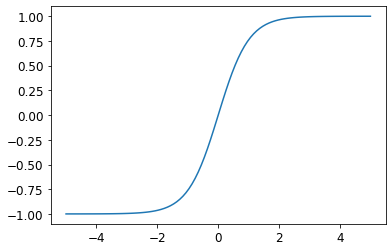

In [65]:
plot_function(torch.tanh, min=-5, max=5)

## Plotting the Labels Embedding:

In [289]:
decoder = learn.model[-1].attn
lbs_emb = decoder.lbs_emb.weight.data

In [290]:
# torch.save(lbs_emb, 'embedding.pkl')

In [51]:
lbs_emb = torch.load('embedding.pkl')
test_eq(lbs_emb.shape, (len(lbls), 400))

Now let's do a PCA and t-SNE on the labels embedding:

In [52]:
X = to_np(lbs_emb)

Before doing PCA we need to standardize `X`:

In [294]:
X = StandardScaler().fit_transform(X)

Next, for PCA we need to figure out how many dimensions we need to explain a significant fraction of the variance in `X`:

In [53]:
# we can adjust the number of components later
n_comps = 300
pca, tsne = PCA(n_components=n_comps), TSNE(n_components=2, perplexity=40, verbose=2)
X_pca, X_tsne = pca.fit_transform(X), tsne.fit_transform(X)

/home/deb/miniconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/deb/miniconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1271 samples in 0.001s...
[t-SNE] Computed neighbors for 1271 samples in 0.040s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1271
[t-SNE] Computed conditional probabilities for sample 1271 / 1271
[t-SNE] Mean sigma: 0.726872
[t-SNE] Computed conditional probabilities in 0.028s
[t-SNE] Iteration 50: error = 75.5997696, gradient norm = 0.3151530 (50 iterations in 0.134s)
[t-SNE] Iteration 100: error = 77.0818100, gradient norm = 0.2670344 (50 iterations in 0.128s)
[t-SNE] Iteration 150: error = 77.7702484, gradient norm = 0.2822770 (50 iterations in 0.136s)
[t-SNE] Iteration 200: error = 77.3227005, gradient norm = 0.2739895 (50 iterations in 0.118s)
[t-SNE] Iteration 250: error = 76.9475479, gradient norm = 0.2677399 (50 iterations in 0.116s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 76.947548
[t-SNE] Iteration 300: error = 2.0935290, gradient norm = 0.0017528 (50 iterations in 0.101s

In [54]:
pca.explained_variance_ratio_.sum()

0.98515093

In [ ]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1, 1, 1)
plt.scatter(X_pca[:, 0], X_pca[:, 1])
plt.show()

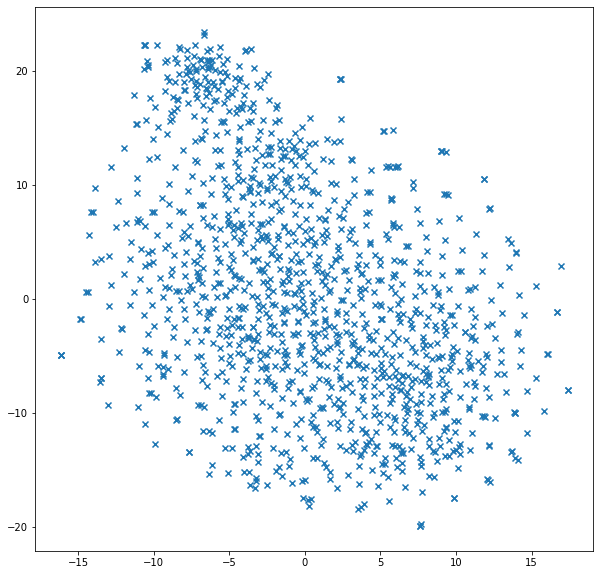

In [56]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1, 1, 1)
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], marker='x')
plt.show()

#### Step 1: Data Preprocessing- Normalization and Scaling

In [242]:
X = to_np(lbs_emb)
X_copy = X.copy()

Training set:
* $x^1, \cdots, x^m$ where $x^i \in \mathbb{R}^n$

In [243]:
mu, std = X.mean(axis=0), X.std(axis=0)
mu.shape, std.shape

((400,), (400,))

In [244]:
X = (X-mu)/std
X_copy = StandardScaler().fit_transform(X_copy)
assert np.allclose(X, X_copy, atol=1e-5)

#### Step 2: Compute the Covariance Matrix:

$$
\Sigma = \frac{1}{m} \sum_{i=1}^{m} x^i {x^i}^{T}
$$

In [245]:
m, n = X.shape
m,n

(1271, 400)

In [246]:
sigma = 1/m * X.T @ X
sigma.shape

(400, 400)

#### Step 3: Compute the Eigen Vectors of `Sigma` (using SVD):

In [247]:
u, s, vh = np.linalg.svd(sigma)
test_eq((u.shape, s.shape, vh.shape), ((400, 400), (400,), (400, 400)))

#### Step 4: Take the first $k$ columns of `u` -> these are the direction vectors (or mathematically, the first $k$ eigen vectors of `sigma`)

In [248]:
n_comps = 300
u_red = u[:, :n_comps]

#### Step 5: Compute the projections, $z_i \in \mathbb{R}^k$

$z^i = u_{\textsf{red}}^Tx^i$

In [249]:
Z = X @ u_red 

#### Step 6: Choosing the number of principal components:

* Total variation in the data: $\frac{1}{m} \sum_{i}^{m} ||x^i||^2$
* Squared projection error: $\frac{1}{m} \sum_{i}^{m} ||x^i - z^i||^2$
* Choose $k$ to be the samllest value such that $\frac{\frac{1}{m} \sum_{i}^{m} ||x^i - z^i||^2}{\frac{1}{m} \sum_{i}^{m} ||x^i||^2} \leq 0.01 (\text{or } 0.05)$
* **Shortcut:** $\frac{\sum_i^k s_{ii}}{\sum_i^n s_{ii}} >= 0.99 (\text{or } 0.95)$

In [250]:
var_exp = np.sum(s[:n_comps])/np.sum(s)
var_exp

0.9851864

The first two principal components explains only ~18% of the variance, but let's cross our fingers and toss some matplotlib into the mix

In [253]:
np.sum(s[:2])/np.sum(s)

0.14398894

In [ ]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1, 1, 1)
plt.scatter(-Z[:, 0], -Z[:, 1])
plt.show()

#### Step 7: Plotting the first two principal components:

In [262]:
# df = pd.read_csv(path.parent/'code_descriptions.csv')
# desc = dict([(row.ICD9_code, row.description)for row in df.itertuples()])

In [263]:
# import pickle
# with open(path.parent/'code_desc.pkl', 'wb') as f:
#     pickle.dump(desc, f)

In [57]:
with open(path.parent/'code_desc.pkl', 'rb') as f: desc = pickle.load(f)

In [58]:
df_lbl = pd.DataFrame([(lbl, desc.get(lbl, "not found"), freq) for lbl, freq in lbl_freqs.items()], columns=['label', 'description', 'frequency'])
df_lbl = df_lbl.sort_values(by='frequency', ascending=False, ignore_index=True)
df_lbl.head(10)

,label,description,frequency
0,401.9,Unspecified essential hypertension,84
1,38.93,"Venous catheterization, not elsewhere classified",77
2,428.0,"Congestive heart failure, unspecified",61
3,272.4,Other and unspecified hyperlipidemia,60
4,427.31,Atrial fibrillation,56
5,414.01,Coronary atherosclerosis of native coronary artery,56
6,584.9,"Acute renal failure, unspecified",49
7,96.04,Insertion of endotracheal tube,48
8,250.00,"type II diabetes mellitus [non-insulin dependent type] [NIDDM type] [adult-onset type] or unspecified type, not stated as uncontrolled, without mention of complication",45
9,518.81,Acute respiratory failure,42


In [ ]:
tfm_cat[]

Instead of doing a PCA on all the labels, let's do it on the 100 most frequent labels:

In [85]:
top = 500
top_lbs = [k for k, v in lbl_freqs.most_common(top)]

In [86]:
top_lbs_emb = lbs_emb[tfm_cat(top_lbs)]

In [87]:
topX = to_np(top_lbs_emb)

In [88]:
topX.shape

(500, 400)

In [89]:
topX_tsne = TSNE(n_components=2, perplexity=40).fit_transform(topX)

/home/deb/miniconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/deb/miniconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


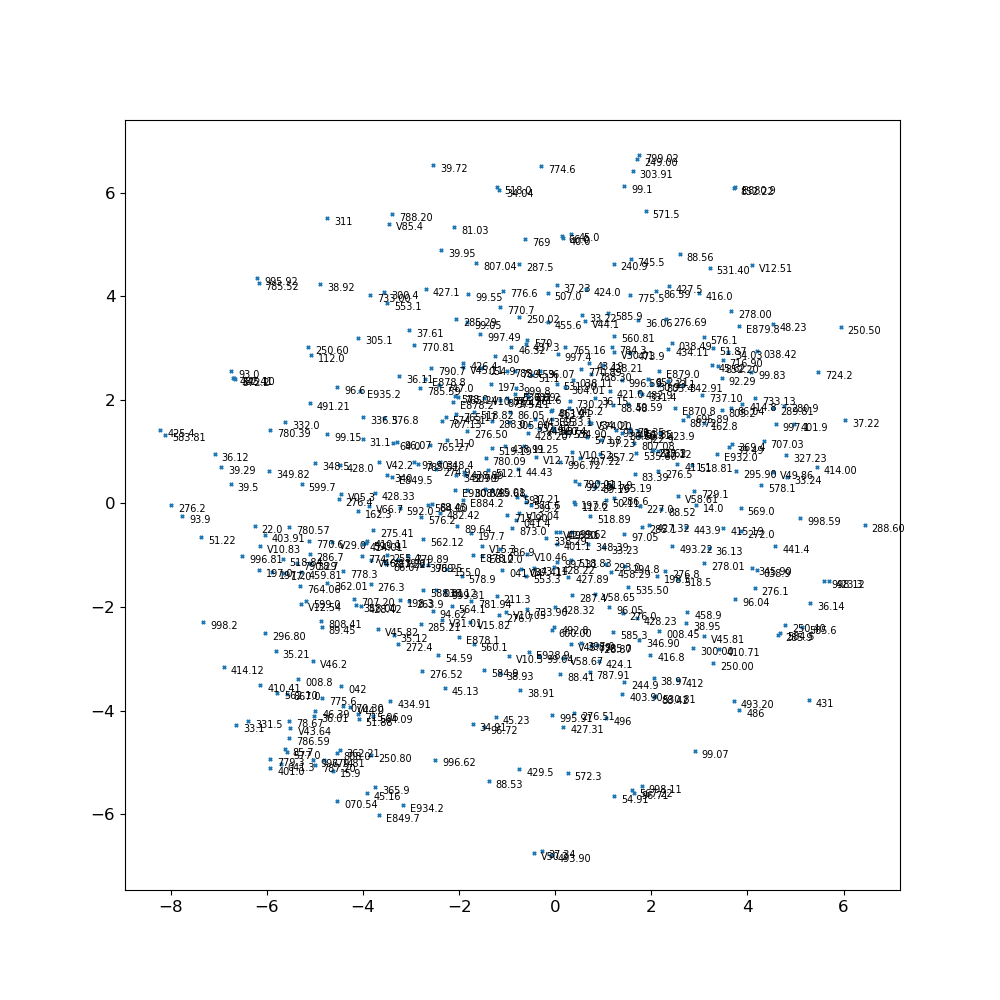

In [90]:
%matplotlib widget
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1, 1, 1)
plt.scatter(topX_tsne[:, 0], topX_tsne[:, 1], marker='x', s=5)
for lbl, x, y in zip(top_lbs, topX_tsne[:, 0], topX_tsne[:, 1]):
    plt.annotate(lbl,
                xy=(x,y),
                xytext=(5,-5),
                textcoords='offset points',
                size=7)
plt.show()

In [76]:
tfm_cat(['36.12', '36.06'])

TensorMultiCategory([454, 683])

In [92]:
df_lbl[df_lbl.label.isin(['54.91', '96.71', '567.22', '998.11'])]

,label,description,frequency
14,96.71,Continuous mechanical ventilation for less than 96 consecutive hours,33
54,54.91,Percutaneous abdominal drainage,14
91,998.11,Hemorrhage complicating a procedure,8
312,567.22,Peritoneal abscess,3
